In [287]:
%load_ext pycodestyle_magic
%flake8_on

The pycodestyle_magic extension is already loaded. To reload it, use:
  %reload_ext pycodestyle_magic


In [288]:
import pyro
import torch
import math
import time
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyro.distributions as dist
from torch.distributions import constraints
from torch.distributions.constraints import positive
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
from IPython import display

Note: data should be in (nwords, ndocs) shape for pyro.plate() to work correctly

In [289]:
from LdaVI.bbvi import LDABBVI

In [142]:
# Lood and process dataset (each row is an order)
data_raw = pd.read_csv(os.path.join("data", "order_data2.csv")).T
print("Sample order:", data_raw.iloc[:5, 0].values)

# Map words to id
vocab = set(data_raw.values.reshape(-1))
word_to_id = {word: i for i, word in enumerate(vocab)}
id_to_word = {i: word for i, word in enumerate(vocab)}
data = data_raw.applymap(lambda word: word_to_id[word])
data = torch.FloatTensor(data.values)[:, :]

print("Data shape: ", data.shape)
# Parameters
nwords, ndocs = data.shape
ntopics = 5
vocab_size = len(vocab)

Sample order: ['Celery' 'Spinach' 'Kirby' 'Yoghurt' 'Avocado']
Data shape:  torch.Size([10, 5000])


Note on selecting alpha and beta prior:

- Consider asymmetrical priors for documents over topics, but not asymmetrical priors

http://dirichlet.net/pdf/wallach09rethinking.pdf

In [123]:
from gensim.models.ldamodel import LdaModel
from gensim import corpora

In [145]:
dictionary = corpora.Dictionary(data_raw.values.T)
corpus = [dictionary.doc2bow(text) for text in data_raw.values.T]

NUM_TOPICS = 10
ldamodel = LdaModel(corpus, num_topics=NUM_TOPICS, id2word=id_to_word, passes=15)
ldamodel.save('model5.gensim')

5:80: E501 line too long (81 > 79 characters)


In [146]:
topics = ldamodel.print_topics(num_words=5)
for topic in topics:
    print(topic)

(0, '0.044*"Buns" + 0.040*"Booster" + 0.039*"Punch" + 0.036*"Citrus" + 0.036*"Peaches"')
(1, '0.366*"Jam" + 0.039*"Wildflower" + 0.025*"Kumato" + 0.021*"Noodles" + 0.021*"Jar"')
(2, '0.042*"Frappuccino" + 0.039*"Midgees" + 0.032*"Queso" + 0.030*"Citrus" + 0.029*"Mustard"')
(3, '0.065*"Booster" + 0.048*"Balm" + 0.031*"Citrus" + 0.031*"Buns" + 0.030*"Prepared"')
(4, '0.177*"Toasty" + 0.070*"Citrus" + 0.054*"Pick-A-Size" + 0.042*"Mayonnaise" + 0.028*"Booster"')
(5, '0.110*"CoffeeCreamer" + 0.041*"Quinine" + 0.026*"Naked" + 0.024*"Buns" + 0.023*"Mascarpone"')
(6, '0.051*"Bandages" + 0.048*"Merlot" + 0.043*"Citrus" + 0.042*"Fennel" + 0.034*"Almondmilk"')
(7, '0.110*"coke" + 0.057*"Balm" + 0.037*"Drink" + 0.036*"Gallon" + 0.028*"Meadow"')
(8, '0.083*"Booster" + 0.032*"Milkfat" + 0.030*"Poppers" + 0.026*"Nectarine" + 0.024*"Jar"')
(9, '0.057*"Crunch" + 0.029*"Citrus" + 0.029*"Merlot" + 0.018*"Noodles" + 0.017*"Crisps"')


In [110]:
def lda(data):
    alpha_prior = torch.randint(1, 10, (ntopics,)).double()
    beta_prior = torch.ones(ntopics, vocab_size)
    words = []
    with pyro.plate("doc_loop", ndocs) as ind:
        data = data[:, ind]
        theta = pyro.sample("theta", dist.Dirichlet(alpha_prior))
        with pyro.plate("word_loop", nwords):
            z = pyro.sample("z", dist.Categorical(theta))
            w = pyro.sample("w", dist.Categorical(beta_prior[z]), obs=data)
            words.append(w)
    return words


def guide(data):
    gamma_q = pyro.param(
        "gamma_q", torch.ones(ndocs, ntopics), constraint=positive
    )
    phi_q = pyro.param(
        "phi_q", torch.ones(nwords, ndocs, ntopics), constraint=positive
    )
    with pyro.plate("doc_loop", ndocs):
        theta = pyro.sample("theta", dist.Dirichlet(gamma_q))
        with pyro.plate("word_loop", nwords):
            z = pyro.sample("z", dist.Categorical(phi_q))
    return theta, z


def smoothed_lda(data):
    alpha_prior = torch.ones(ntopics)
    nu_prior = torch.ones(vocab_size)
    with pyro.plate("topic_loop", ntopics):
        topics = pyro.sample(
            "topics", dist.Dirichlet(nu_prior.repeat(ntopics, 1))
        )
    with pyro.plate("doc_loop", ndocs) as ind:
        data = data[:, ind]
        theta = pyro.sample("theta", dist.Dirichlet(alpha_prior))
        with pyro.plate("word_loop", nwords):
            pyro.sample("z", dist.Categorical(theta))
            pyro.sample("w", dist.Categorical(topics[z]), obs=data)


def smoothed_guide(data):
    lambda_q = pyro.param(
        "lambda_q", torch.ones(ntopics, vocab_size),
        constraint=constraints.positive
    )
    gamma_q = pyro.param(
        "gamma_q", torch.ones(ndocs, ntopics),
        constraint=constraints.positive
    )
    phi_q = pyro.param(
        "phi_q", torch.ones(nwords, ndocs, ntopics),
        constraint=constraints.positive
    )

    with pyro.plate("topic_loop", ntopics):
        topics = pyro.sample("topics", dist.Dirichlet(lambda_q))
    with pyro.plate("doc_loop", ndocs):
        theta = pyro.sample("theta", dist.Dirichlet(gamma_q))
        with pyro.plate("word_loop", nwords):
            z = pyro.sample("z", dist.Categorical(phi_q))
    return topics, theta, z

In [111]:
def run_svi(model, guide, data, num_particles=1, adam_params={},
            retrain=False, plot=True, n_steps=100):
    if not retrain:
        pyro.clear_param_store()
    opt = Adam(adam_params)
    svi = SVI(model, guide, opt, loss=Trace_ELBO(num_particles=num_particles))
    loss = []
    plt.figure(figsize=(10, 3)), plt.xlim(0, n_steps)
    for step in range(n_steps):
        curr_loss = svi.step(data)
        loss.append(curr_loss)
        if step % (n_steps // 25) == 0:
            if plot:
                if plt.gca().lines != []:
                    plt.gca().lines.pop()
                    plt.gca().lines.pop()
                display.clear_output(wait=True)
                plt.plot(loss, c="steelblue", alpha=0.9, linewidth=1)
                plt.plot(pd.Series(loss).rolling(50).mean(), c="orange")
                display.display(plt.gcf())
            else:
                print(n_step // step * 100, end=".")
    if plot:
        display.clear_output(wait=True)
    return loss

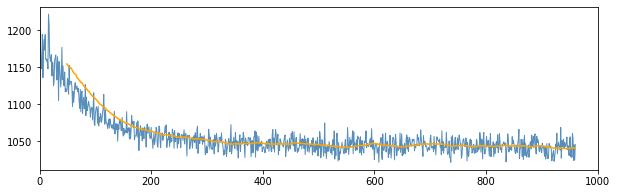

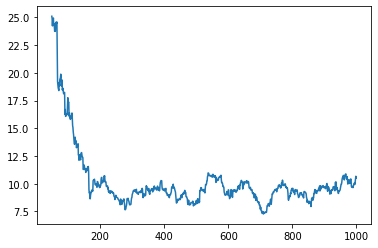

2:80: E501 line too long (89 > 79 characters)


In [102]:
adam_params = {"lr": 0.01, "betas": (0.99, 0.999)}
loss = run_svi(lda, guide, data, num_particles=10, adam_params=adam_params, n_steps=1000)
plt.show()
pd.Series(loss).rolling(50).std().plot()

NameError: name 'z' is not defined

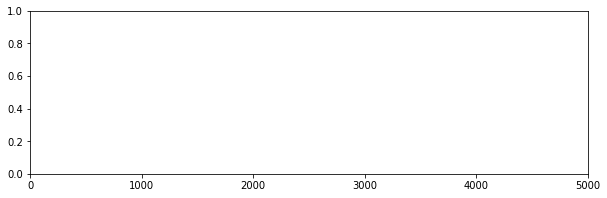

2:80: E501 line too long (107 > 79 characters)


In [113]:
adam_params = {"lr": 0.001, "betas": (0.99, 0.999)}
loss = run_svi(smoothed_lda, smoothed_guide, data, num_particles=10, adam_params=adam_params, n_steps=5000)
plt.show()
pd.Series(loss).rolling(50).std().plot()

In [ ]:
# Run SVI
adam_params = {"lr": 0.001, "betas": (0.99, 0.999)}
model = lda
guide = guide
batch_size = 1
n_steps = 100

pyro.clear_param_store()
opt = Adam(adam_params)
svi = SVI(model, guide, opt, loss=Trace_ELBO(num_particles=batch_size), loss_and_grads=True)
loss = []
plt.figure(figsize=(10, 4)), plt.xlim(0, n_steps)
for step in range(n_steps):
    curr_loss = svi.step(data)
    loss.append(curr_loss)
    if step % (n_steps // 50) == 0:
            try:
                plt.gca().lines.pop()
                plt.gca().lines.pop()
            except:
                pass
            display.clear_output(wait=True)
            plt.plot(loss, c="steelblue", alpha=0.9, linewidth=1)
            plt.plot(pd.Series(loss).rolling(50).mean(), c="orange")
            display.display(plt.gcf())

#### MC Method Analysis

$$ E_{q(\theta, z)} [\log q(\theta, z)] $$

In [191]:
def mc(sampling_dist, func, num_trials=200, num_samples=100):
    eval_means = []
    for _ in range(num_trials):
        evals = []
        for i in range(num_samples):
            x_i = pyro.sample('x_{}'.format(i), sampling_dist)
            evals.append(func(x_i).numpy())
        eval_means.append(np.mean(evals, axis=0))
    eval_means = np.array(eval_means)
    return eval_means

10:5: E265 block comment should start with '# '
11:5: E265 block comment should start with '# '
11:80: E501 line too long (82 > 79 characters)
12:5: E265 block comment should start with '# '


In [279]:
func = lambda x: x**2
sampling_dist = dist.Dirichlet(sampling_param)
num_params = [2,5,10,100,500,1000]
exponent = 1
num_trials = 100
num_samples = 500
stds = []
for num_param in num_params:
    print(num_param)
    param = torch.FloatTensor(abs(np.random.randn(num_param))**exponent)
    sampling_param = torch.FloatTensor(abs(np.random.randn(num_param))**exponent)
    param /= param.sum()
    sampling_param /= sampling_param.sum()
    
    means = mc(sampling_dist, func, num_trials=num_trials, num_samples=num_samples)

    std_adj = (means.std(0) / (means.mean(0) + 1e-15)).mean()
    stds.append(std_adj)

2
5
10
100
500
1000


1:1: E731 do not assign a lambda expression, use a def
3:16: E231 missing whitespace after ','
3:18: E231 missing whitespace after ','
3:21: E231 missing whitespace after ','
3:25: E231 missing whitespace after ','
3:29: E231 missing whitespace after ','
11:80: E501 line too long (81 > 79 characters)
14:1: W293 blank line contains whitespace
15:80: E501 line too long (83 > 79 characters)


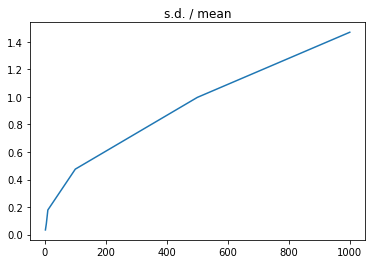

2:25: E703 statement ends with a semicolon


In [278]:
plt.plot(num_params, stds)
plt.title('s.d. / mean');

In [285]:
func = lambda x: x**3
sampling_dist = dist.Dirichlet(sampling_param)
num_params = [2,10,100,1000]
exponent = 1
num_trials = 100
num_samples = 500
stds = []
for num_param in num_params:
    print(num_param)
    param = torch.FloatTensor(abs(np.random.randn(num_param))**exponent)
    sampling_param = torch.FloatTensor(abs(np.random.randn(num_param))**exponent)
    param /= param.sum()
    sampling_param /= sampling_param.sum()
    
    means = mc(sampling_dist, func, num_trials=num_trials, num_samples=num_samples)

    std_adj = (means.std(0) / (means.mean(0) + 1e-15)).mean()
    stds.append(std_adj)

2
10
100
1000


1:1: E731 do not assign a lambda expression, use a def
3:16: E231 missing whitespace after ','
3:19: E231 missing whitespace after ','
3:23: E231 missing whitespace after ','
11:80: E501 line too long (81 > 79 characters)
14:1: W293 blank line contains whitespace
15:80: E501 line too long (83 > 79 characters)


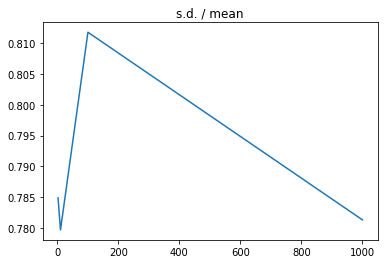

2:25: E703 statement ends with a semicolon


In [286]:
plt.plot(num_params, stds)
plt.title('s.d. / mean');

In [ ]:
num_iters = 200
num_samples = 500

vocab_size = 1000
def f(x):
    if x <= 20:
        return 50
    return 0.5

ests_f = []
ests_g = []
for _ in range(num_iters):
    ests_f.append(np.mean([f(s) for s in np.random.randint(0, vocab_size + 1, num_samples)]))

plt.figure(figsize=(12,2))
plt.bar(np.arange(0, vocab_size+1), [f(x) for x in np.arange(0, vocab_size+1)]), plt.show();
plt.hist(ests_f);
#plt.hist(ests_g);

In [ ]:
num_iters = 200
num_samples = 1000

f = lambda x: np.cos(x)
g = lambda x: np.cos(x/3)  # smoother
ests_f = []
ests_g = []
for _ in range(num_iters):
    ests_f.append(np.mean([f(s) for s in np.random.randn(num_samples)]))
    ests_g.append(np.mean([g(s) for s in np.random.randn(num_samples)]))
    
plt.hist(ests_f), plt.hist(ests_g);

In [ ]:
gamma_q = pyro.param("gamma_q")
phi_q = pyro.param("phi_q")

In [ ]:
# Get params
#lambda_q = pyro.param("lambda_q")
gamma_q = pyro.param("gamma_q")
phi_q = pyro.param("phi_q")

param_round = {
    #"lambda": lambda_q.detach().numpy().round(3),
    "gamma": gamma_q.detach().numpy().round(3),
    "phi": phi_q.detach().numpy().round(3),
}

topic, theta, z = guide(data)

# Get topics
t = []
for i in range(ntopics):
    s = pd.Series(topic.detach().numpy()[i])
    # s.index = vocab
    t.append(s.sort_values(ascending=False).head(10))
pd.concat([x.reset_index() for x in t], axis=1)

In [ ]:
def generate(alpha_prior, beta_prior):
    data = torch.zeros([nwords, ndocs])
    topics = beta_prior
    for d in pyro.plate("doc_loop", ndocs):
        theta = pyro.sample(f"theta_{d}", dist.Dirichlet(alpha_prior))
        for w in pyro.iarange("word_loop", nwords):
            z = pyro.sample(f"z{d}_{w}", dist.Categorical(theta))
            word = pyro.sample(f"w{d}_{w}", dist.Categorical(topics[z.item()]))
            data[w, d] = word
    return data, topics


# alpha_prior = torch.randint(1, 10, (ntopics,)).double().sort()[0] ** 3
# beta_prior = torch.randint(1, 10, (ntopics, vocab_size)).double() ** 3
# data, topics = generate(alpha_prior, beta_prior)
# data.shape

### TESTING

In [83]:
from pyro import poutine

In [92]:
conditioned_model = poutine.condition(lda, data=data)
guide_tr = poutine.trace(guide).get_trace(data)
model_tr = poutine.trace(poutine.replay(conditioned_model, trace=guide_tr)).get_trace(data)
monte_carlo_elbo = model_tr.log_prob_sum() - guide_tr.log_prob_sum()

RuntimeError: Tensor.__contains__ only supports Tensor or scalar, but you passed in a <class 'str'>.
Trace Shapes:
 Param Sites:
Sample Sites:

3:80: E501 line too long (91 > 79 characters)


In [80]:
pyro.clear_param_store()
t = pt.trace(guide)
tr = t.get_trace(data)
# pt.replay(fn, trace=tr)

4:1: E265 block comment should start with '# '


In [ ]:

fn_inner = pt.trace(fn)
fn_outer = pt.trace(block(fn_inner, hide=["a"]))
trace_inner = fn_inner.get_trace()
trace_outer  = fn_outer.get_trace()